# X3 Denoising

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py as h5
import torch as th

C:\Users\braun\AppData\Local\Temp\ipykernel_15432\3973438280.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Download the data from GDrive [file1](https://drive.google.com/file/d/1rQZwNN9HC_3uyd3JRpBB2cY10vEYVM2H/view?usp=drivesdk)
### Download the data from GDrive [file2](https://drive.google.com/file/d/12yZqhx6yxLrty9seXL8V5yueQ5YPUr-1/view?usp=drivesdk)

### or use the following code to download the data

In [14]:
import gdown
# Google Drive file ID from the shareable link
file_id1 = "1rQZwNN9HC_3uyd3JRpBB2cY10vEYVM2H"  # Replace with actual file ID
output_path2 = "./03_denoising_SrTiO3_High_mag_Low_dose.npy"
file_id2 = "12yZqhx6yxLrty9seXL8V5yueQ5YPUr-1"  # Replace with actual file ID
output_path1 = "./03_denoising_SrTiO3_High_mag_High_dose.npy"

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path1), exist_ok=True)
os.makedirs(os.path.dirname(output_path2), exist_ok=True)

# Download file from Google Drive
url = f'https://drive.google.com/uc?id={file_id1}'
gdown.download(url, output_path1, quiet=False)
url = f'https://drive.google.com/uc?id={file_id2}'
gdown.download(url, output_path2, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1rQZwNN9HC_3uyd3JRpBB2cY10vEYVM2H
From (redirected): https://drive.google.com/uc?id=1rQZwNN9HC_3uyd3JRpBB2cY10vEYVM2H&confirm=t&uuid=e8f4023f-b417-46c9-802c-c595f95fb89b
To: c:\Users\braun\OneDrive\Documents\GitHub\DataScienceForElectronMicroscopy\notebooks\03_denoising_SrTiO3_High_mag_High_dose.npy
100%|██████████| 604M/604M [00:05<00:00, 109MB/s]  
Downloading...
From (original): https://drive.google.com/uc?id=12yZqhx6yxLrty9seXL8V5yueQ5YPUr-1
From (redirected): https://drive.google.com/uc?id=12yZqhx6yxLrty9seXL8V5yueQ5YPUr-1&confirm=t&uuid=782a9f65-65cc-4701-a9f9-826b36469454
To: c:\Users\braun\OneDrive\Documents\GitHub\DataScienceForElectronMicroscopy\notebooks\03_denoising_SrTiO3_High_mag_Low_dose.npy
100%|██████████| 604M/604M [00:07<00:00, 81.4MB/s] 


'./03_denoising_SrTiO3_High_mag_Low_dose.npy'

In [15]:
file_path_low = './03_denoising_SrTiO3_High_mag_Low_dose.npy'
file_path_high = './03_denoising_SrTiO3_High_mag_High_dose.npy'

data_low_dose = np.load(file_path)

print(f"Data shape: {data_low_dose.shape}")

ds = data_low_dose.shape

data3d_low = data_low_dose.reshape(ds[0]*ds[1], ds[2], ds[3])

print(f"Data3d shape: {data3d_low.shape}")



data_high_dose = np.load(file_path_high)
print(f"High dose data shape: {data_high_dose.shape}")
ds_high = data_high_dose.shape
data3d_high = data_high_dose.reshape(ds_high[0]*ds_high[1], ds_high[2], ds_high[3])
print(f"High dose data3d shape: {data3d_high.shape}")

Data shape: (256, 256, 48, 48)
Data3d shape: (65536, 48, 48)
High dose data shape: (256, 256, 48, 48)
High dose data3d shape: (65536, 48, 48)


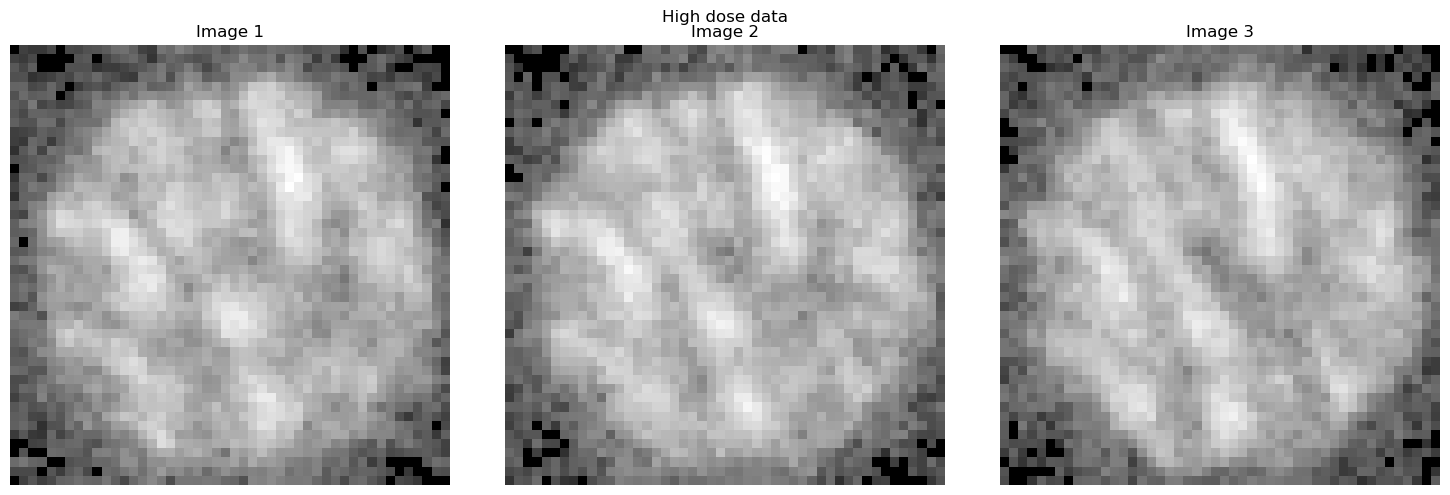

In [17]:
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(data3d_high[i+1000]**0.25, cmap='gray')
    plt.title(f'Image {i+1}')
    plt.axis('off')
plt.suptitle('High dose data')

plt.tight_layout()
plt.show()

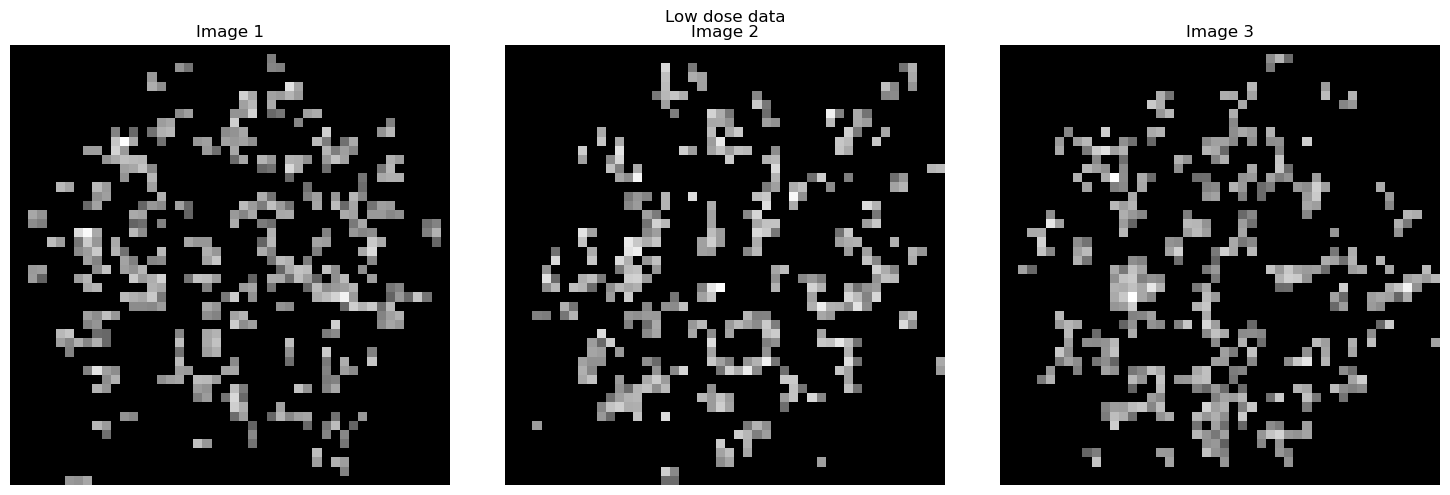

In [18]:
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(data3d_low[i+1000]**0.25, cmap='gray') 
    plt.title(f'Image {i+1}')
    plt.axis('off')
plt.suptitle('Low dose data')

plt.tight_layout()
plt.show()


In [19]:
# Training loop
num_epochs = 3
batch_size = 32

data3dt = th.from_numpy(data3d).float().unsqueeze(1).cuda()
data3dt -= data3dt.min()
data3dt /= data3dt.max()